In [1]:
import multiprocessing
print(f'Using {multiprocessing.cpu_count()} CPUs')

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
import sklearn.datasets
import scipy as sp

import frame_whitening as fw
import frame_whitening.plot as fwplt
import frame_whitening.simulation as fws

Using 128 CPUs


100%|█████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 10874.05it/s]


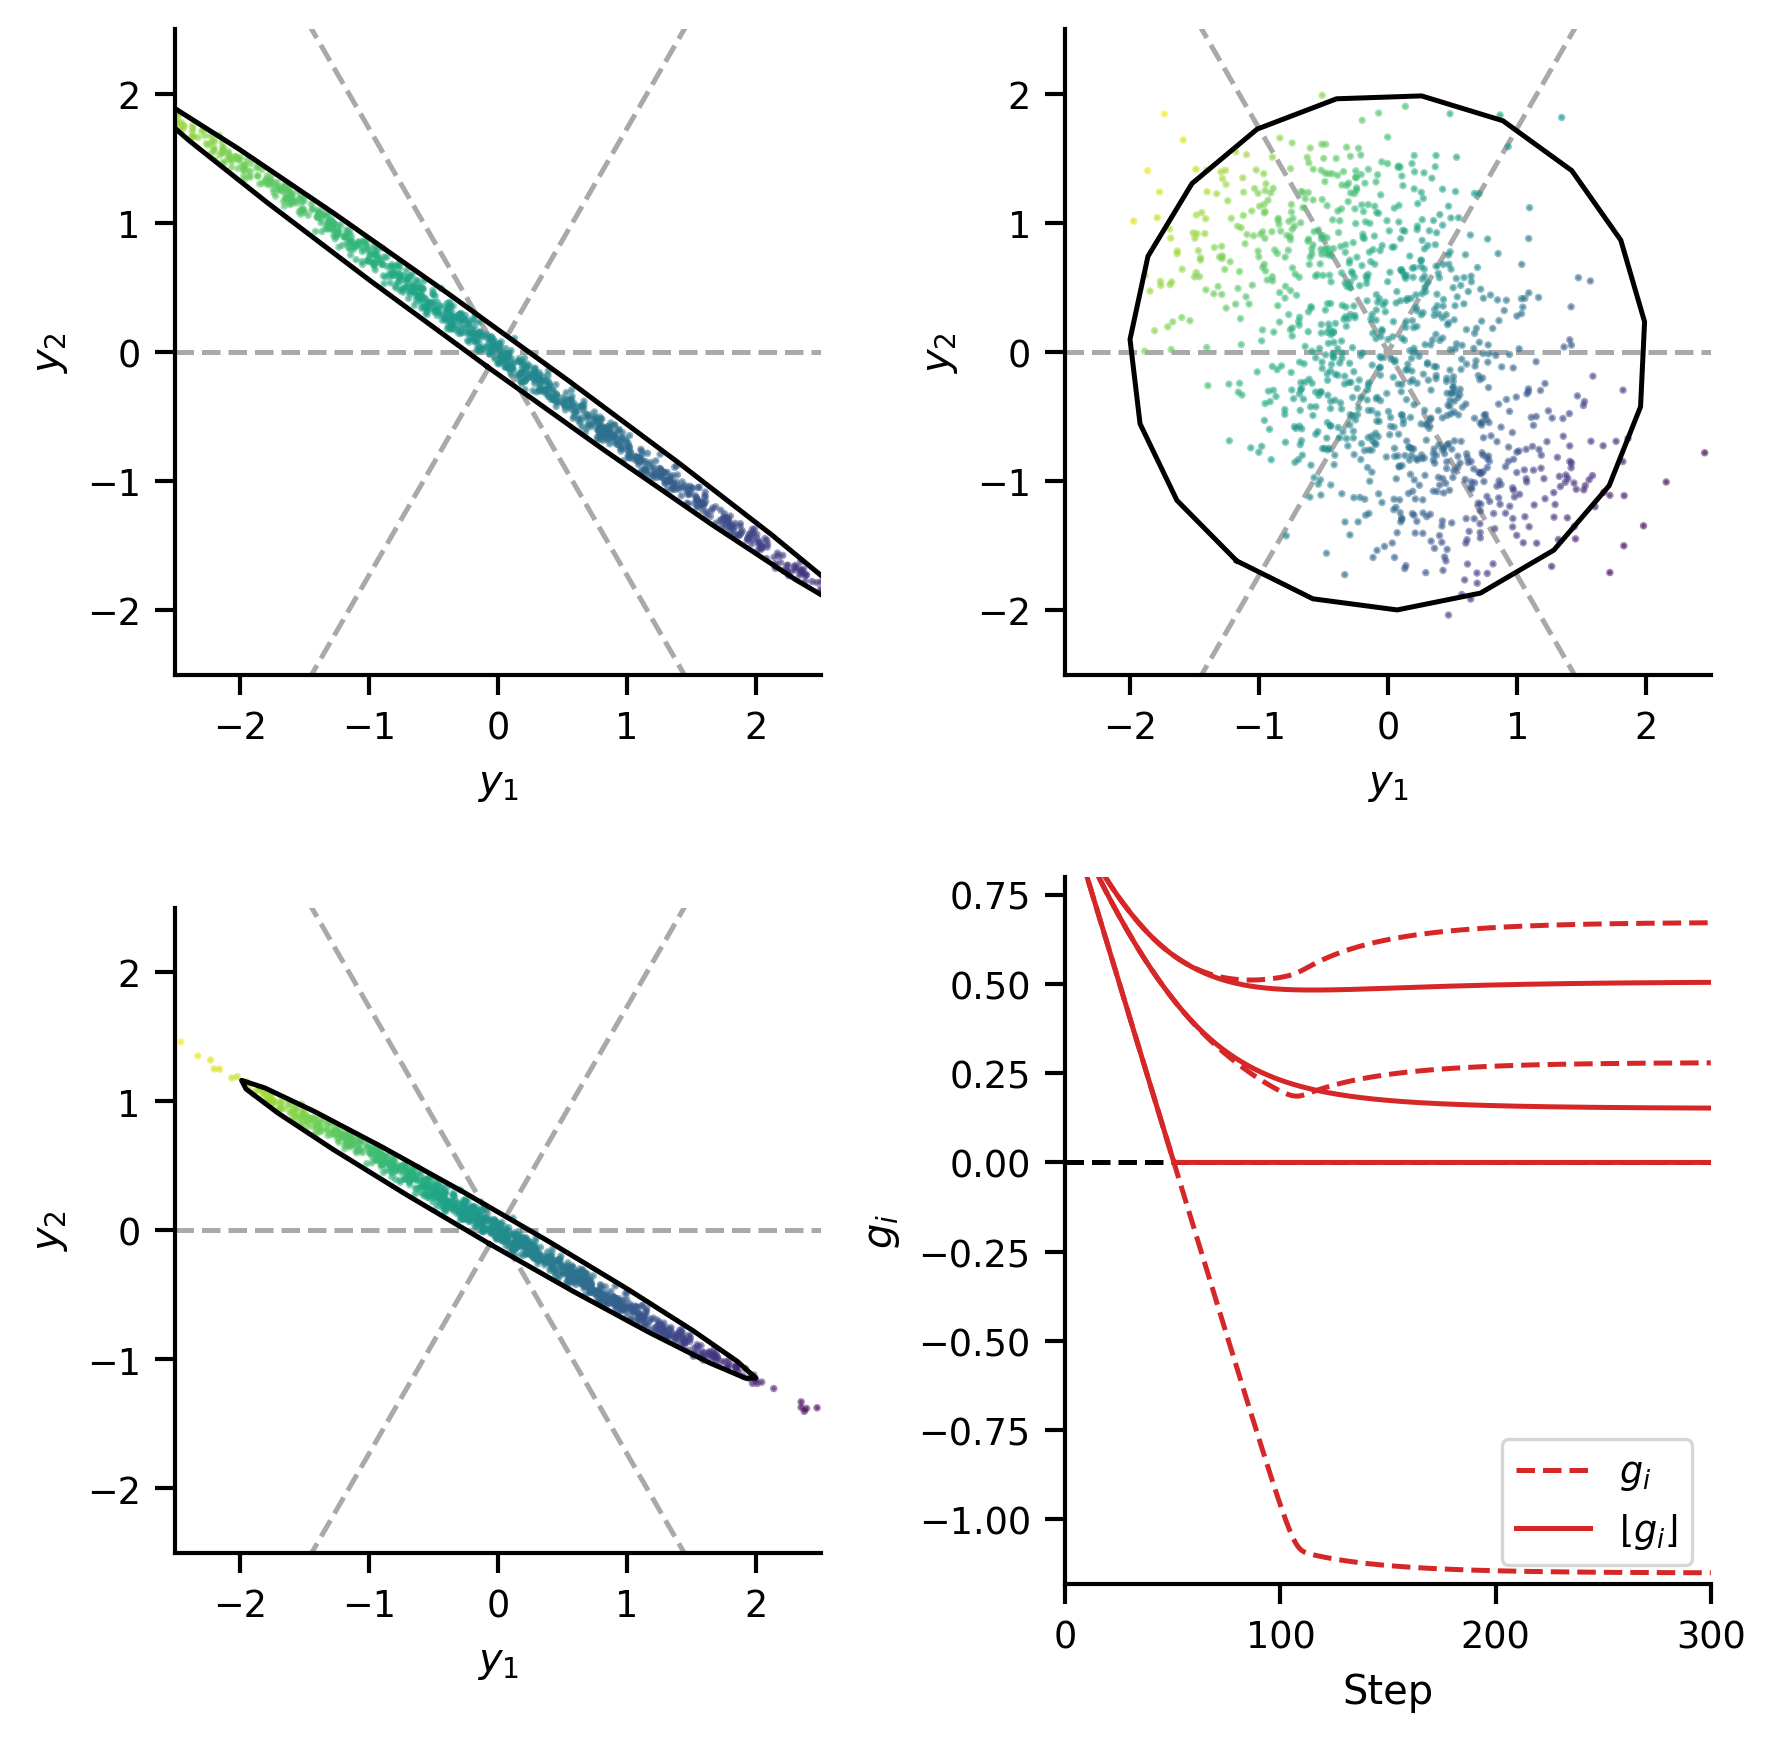

In [4]:
n_samples = 1000
X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.4)
X -= X.mean(axis=0)

# Construct ill-conditioned 2D covariance matrix
rng = np.random.default_rng(42069)
s = [3, 5e-3]
N = 2
V, _ = np.linalg.qr(rng.standard_normal((N, N)))

Cxx = V @ np.diag(s) @ V.T
Lxx = np.linalg.cholesky(Cxx)
X = X @ Lxx.T
W = fw.get_mercedes_frame()
W = fw.normalize_frame(W)

n_batch = 300
lr_g = 2e-2
g_last, g_all, err, var = fws.adapt_covariance(
                                Cxx_list=[Cxx], 
                                W=W, 
                                n_batch=n_batch,
                                lr_g=lr_g,
                                g0=None,
                                clamp=True,
                                online=False,
                                )

F_clamp = np.linalg.inv(np.eye(2) + W @ np.diag(g_all[-1]) @ W.T)

g_last0, g_all0, err0, var0 = fws.adapt_covariance(
                                Cxx_list=[Cxx], 
                                W=W, 
                                n_batch=n_batch,
                                lr_g=lr_g,
                                g0=None,
                                clamp=False,
                                online=False,
                                )


F = np.linalg.inv(np.eye(N) + W @ np.diag(g_all0[-1]) @ W.T)

def plot_frame_axes(W, lims, ax):
    x = np.linspace(*lims, 20)
    for w in W.T:
        ax.plot(x, (w[1] / w[0]) * x, '--', color='darkgrey', zorder=0)

cols = X @ V[:, 0].T

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
    axlims = (-2.5, 2.5)
    ax = ax.flatten()
    fwplt.plot_ellipse(Cxx, color='k', label='Cxx', ax=ax[0])
    plot_frame_axes(W, axlims, ax[0])
    # fwplt.plot_frame2d(W, ax=ax[0])
    ax[0].scatter(X[:, 0], X[:, 1], s=1, alpha=.5, c=cols)

    fwplt.plot_ellipse(F @ Cxx @ F, color='k', label='Cxx', ax=ax[1])
    plot_frame_axes(W, axlims, ax[1])
    Fx = X @ F.T
    ax[1].scatter(Fx[:, 0], Fx[:, 1], s=1, alpha=.5, c=cols)

    fwplt.plot_ellipse(F_clamp @ Cxx @ F_clamp, color='k', label='Cxx', ax=ax[2])
    plot_frame_axes(W, axlims, ax[2])
    Fx_clamp = X @ F_clamp.T
    ax[2].scatter(Fx_clamp[:, 0], Fx_clamp[:, 1], s=1, alpha=.5, c=cols)

    col = 'C3'
    # add dummy line and dashed line for legend
    ax[3].plot(0, 0, color=col, linestyle='--', label=r'$g_i$')
    ax[3].plot(0, 0, color=col, linestyle='-', label=r'$\lfloor g_i \rfloor$')
    ax[3].plot(g_all0, '--', color=col)
    ax[3].plot(g_all, color=col)
    ax[3].hlines(0, 0, 300, color='k', linestyle='--', zorder=0)
    ax[3].set(xlim=(0, 300), 
        ylabel=r'$g_i$',
        xlabel='Step',
        ylim=(-1.18, .8),
    )
    ax[3].legend(loc='lower right')

    ax[0].axis('square')
    ax[0].set(xlim=axlims, ylim=axlims, xlabel=r'$y_1$', ylabel=r'$y_2$')

    ax[1].axis('square')
    ax[1].set(xlim=axlims, ylim=axlims, xlabel=r'$y_1$', ylabel=r'$y_2$')


    ax[2].axis('square')
    ax[2].set(xlim=axlims, ylim=axlims, xlabel=r'$y_1$', ylabel=r'$y_2$')

    fig.tight_layout()
    sns.despine()

In [3]:
6 * 7 //2

21